In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [40]:
from flask import Flask

In [41]:
app = Flask(__name__)

In [45]:
@app.route("/")
def hello():
        return "hello world"


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for name in columns:
    print(name['name'],name['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

This is the last row in the table 'measurement': 2017-08-23
2016-08-23
The date a year from 2017-08-23 is 2016-08-23


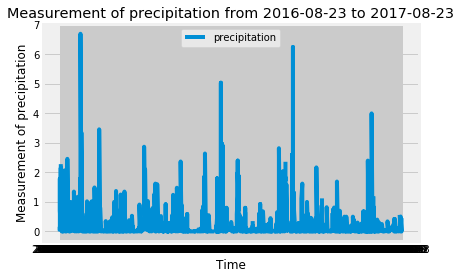

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
    
    # Querying the last row of the table 'measurement'
last_row = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"This is the last row in the table 'measurement': {last_row[-1]}")
    
    # inputting the date in the last row into a 'datetime' variable
last_row_date = dt.date(2017,8,23)
    
    # Calculating date 365 days ago from the last_row_date
calculated_date = last_row_date - dt.timedelta(days = 365)
print(calculated_date)
print(f"The date a year from {last_row_date} is {calculated_date}")
    
# Perform a query to retrieve the data and precipitation scores
measurement_query = session.query(measurement.date, measurement.prcp).filter(measurement.date <= '2017-08-23').filter(measurement.date >='2016-08-23').order_by(measurement.date).all()
measurement_query

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(measurement_query)
measurement_df = measurement_df.set_index('date')
measurement_df

# Sort the dataframe by date
measurement_df = measurement_df.sort_index(axis = 1)
measurement_df

# Use Pandas Plotting with Matplotlib to plot the data
measurement_plot = plt.plot(measurement_df, label = 'precipitation')
plt.title(f"Measurement of precipitation from {calculated_date} to {last_row_date}")
plt.xlabel("Time")
plt.ylabel("Measurement of precipitation")
plt.legend(loc ='upper center')
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe() #This is the line for summary statistics 

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Inspecting the column names for the table 'station'
columns = inspector.get_columns('station')
for name in columns:
    print(name['name'],name['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to show how many stations are available in this dataset?
amount_of_stations = session.query(station).distinct().count()
print(f"There are {amount_of_stations} stations available in this dataset")

There are 9 stations available in this dataset


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity_count = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

most_active_station = station_activity_count[0][0]
most_active_station_count = station_activity_count[0][1]
least_active_station = station_activity_count[8][0]
least_active_station_count = station_activity_count[8][1]
print(f"The station with the most activity is {most_active_station} with an observation count of {most_active_station_count}")
print(f"The station with the least activity is {least_active_station} with an observation count of {least_active_station_count}")

The station with the most activity is USC00519281 with an observation count of 2772
The station with the least activity is USC00518838 with an observation count of 511


In [54]:
practise = session.query(measurement.date, measurement.prcp).all()

In [57]:
practise[0]

0.08

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_stats = session.query(measurement.station, func.min(measurement.tobs),func.max(measurement.tobs), func.avg(measurement.tobs)).group_by(measurement.station).all()
most_active_station_stats = station_stats[-3]
most_active_station_stats
print(f"The lowest tempature for station {most_active_station} is {most_active_station_stats[1]}")
print(f"The highest tempature for station {most_active_station} is {most_active_station_stats[2]}")
print(f"The average tempature for station {most_active_station} is {most_active_station_stats[3]}")


The lowest tempature for station USC00519281 is 54.0
The highest tempature for station USC00519281 is 85.0
The average tempature for station USC00519281 is 71.66378066378067


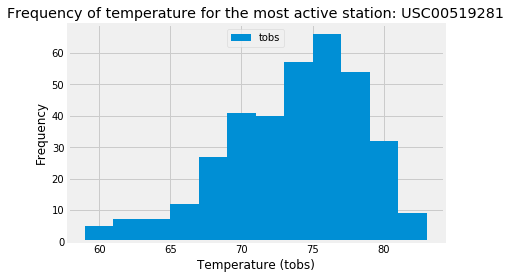

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
    # Creating the query
temperature_query = session.query(measurement.date, measurement.station,measurement.tobs).filter(measurement.station == 'USC00519281').filter(measurement.date <= '2017-08-23').filter(measurement.date >='2016-08-18').all()

    # Inputting the query into a DataFrame
temperature_df = pd.DataFrame(temperature_query)
temperature_df

#Creating the plot
temperature_plot = plt.hist(x = temperature_df.tobs, bins = 12, label ='tobs')
plt.title(f"Frequency of temperature for the most active station: {most_active_station}")
plt.xlabel("Temperature (tobs)")
plt.ylabel("Frequency")
plt.legend(loc = 'upper center')
plt.show()

![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
# Input date as YYYY-MM-DD format
def calc_temps(start_date, end_date):

    #TMIN, TAVG, and TMAX for a list of dates.
     

    #Args:
    start_date = str(start_date)
    end_date = str(end_date)

    calc_temp_query = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

    # Returns:
    # TMIN, TAVE, and TMAX
    TMIN = calc_temp_query[0][0]
    TMAX = calc_temp_query[0][1]
    TAVE = calc_temp_query[0][2]
    
    print(f"The Minimum temperature for the date range you have selected is {TMIN}")
    print(f"The Maximum temperature for the date range you have selected is {TMAX}")
    print(f"The Average temperature for the date range you have selected is {TAVE}")

calc_temps('2015-07-07', '2016-06-06')

The Minimum temperature for the date range you have selected is 56.0
The Maximum temperature for the date range you have selected is 86.0
The Average temperature for the date range you have selected is 74.31598513011153


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2016-08-18','2017-08-23' )

The Minimum temperature for the date range you have selected is 58.0
The Maximum temperature for the date range you have selected is 87.0
The Average temperature for the date range you have selected is 74.63865546218487


[(58.0, 87.0, 74.63865546218487)]


<BarContainer object of 1 artists>

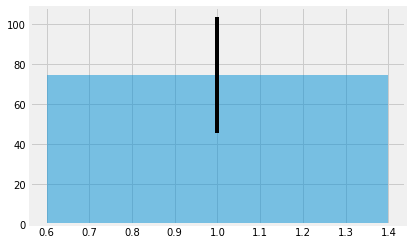

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
calc_temp_query = session.query(measurement.tobs).filter(measurement.date >= '2016-08-18').filter(measurement.date <= '2017-08-23').all()
calc_temp_query2 = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.date >= '2016-08-18').filter(measurement.date <= '2017-08-23').all()
print(calc_temp_query2)

TMIN = calc_temp_query2[0][0]
TMAX = calc_temp_query2[0][1]
TAVG = calc_temp_query2[0][2]

calc_temp_query = [item for sublist in calc_temp_query for item in sublist]

plt.bar(1, TAVG, yerr = (TMAX-TMIN), align = 'center', alpha =0.5)

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
